In [1]:
%cd ..
from manim import *
from matplotlib.pyplot import tight_layout
import matplotlib.ticker as ticker

from manim_custom import *
from manim_mobject_svg import *

import os

memoire_dir = os.environ['memoire']
runs_dir = rf"{memoire_dir}/05-results"

quality = "ql"
config['background_color'] = WHITE

import numpy as np

try:
    import openseespy.opensees as ops


    def analyze_truss_with_opensees(nodes, connectivity_matrix, supports, loads, A_list, E_list):
        """
        Parameters:
            nodes: np.array of shape (n_nodes, 3)
            connectivity_matrix: np.array of shape (n_elements, 2)
            supports: dict {node_index: (fix_x, fix_y)}
            loads: dict {node_index: [Fx, Fy]}
            A_list: list of cross-sectional areas (length = n_elements)
            E_list: list of Young's moduli (length = n_elements)

        Returns:
            displacements: dict {node_index: [ux, uy]}
        """

        ops.wipe()
        ops.model('basic', '-ndm', 2, '-ndf', 2)

        # Create nodes
        for i, (x, y, _) in enumerate(nodes):
            ops.node(i, x, y)

        # Supports
        for node_id, (fix_x, fix_y) in supports.items():
            ops.fix(node_id, int(fix_x), int(fix_y))

        # Define elements and materials
        for i, (ni, nj) in enumerate(connectivity_matrix):
            E = E_list[i]
            A = A_list[i]
            ops.uniaxialMaterial("Elastic", i, E)
            ops.element("truss", i, int(ni), int(nj), A, i)

        # Apply loads
        ops.timeSeries("Linear", 1)
        ops.pattern("Plain", 1, 1)
        for node_id, (Fx, Fy) in loads.items():
            ops.load(node_id, Fx, Fy)

        # Static analysis
        ops.system("SparseGeneral")
        ops.numberer("RCM")
        ops.constraints("Plain")
        ops.integrator("LoadControl", 1.0)
        ops.algorithm("Linear")
        ops.analysis("Static")
        ops.analyze(1)

        # Get displacements
        displacements = np.array([
            [ops.nodeDisp(i, 1), ops.nodeDisp(i, 2)]
            for i in range(len(nodes))
        ])

        forces = np.array([ops.eleResponse(i, 'axialForce')[0] for i in range(len(connectivity_matrix))])

        return displacements, forces
except Exception:
    pass


/Users/aflamant/Documents/courses/2024-2025/mémoire/03-code/memoire/figures


In [2]:
def moving_average(x, alpha):
    avg = [xi for xi in x]
    for i in range(1, len(x)):
        avg[i] = alpha * avg[i] + (1 - alpha) * avg[i - 1]
    return np.array(avg)

[08/11/25 11:11:13] INFO     NumExpr defaulting to 14 threads.                                         ]8;id=201043;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=388744;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/numexpr/utils.py#164\164]8;;\

MLflow server started at http://127.0.0.1:5550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114
Workers: 4
Process group: 73679


[08/11/25 11:11:14] WARNING  Retrying (Retry(total=6, connect=6, read=7, redirect=7,          ]8;id=680278;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=717169;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=7)) after connection broken by                                                 
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x316e87d10>: Failed to establish a new connection: [Errno                         
                             61] Connection refused')':                                                            
                             /api/2.0/mlflow/experiments/get-by-name?experiment_name=training                      

[08/11/25 11:11:19] WARNING  Retrying (Retry(total=5, connect=5, read=7, redirect=7,          ]8;id=809491;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py\connectionpool.py]8;;\:]8;id=240098;file:///Users/aflamant/miniconda3/envs/manim-env/lib/python3.12/site-packages/urllib3/connectionpool.py#868\868]8;;\
                             status=7)) after connection broken by                                                 
                             'NewConnectionError('<urllib3.connection.HTTPConnection object                        
                             at 0x31d5d8bf0>: Failed to establish a new connection: [Errno                         
                             61] Connection refused')':                                                            
                             /api/2.0/mlflow/experiments/get-by-name?experiment_name=training                      

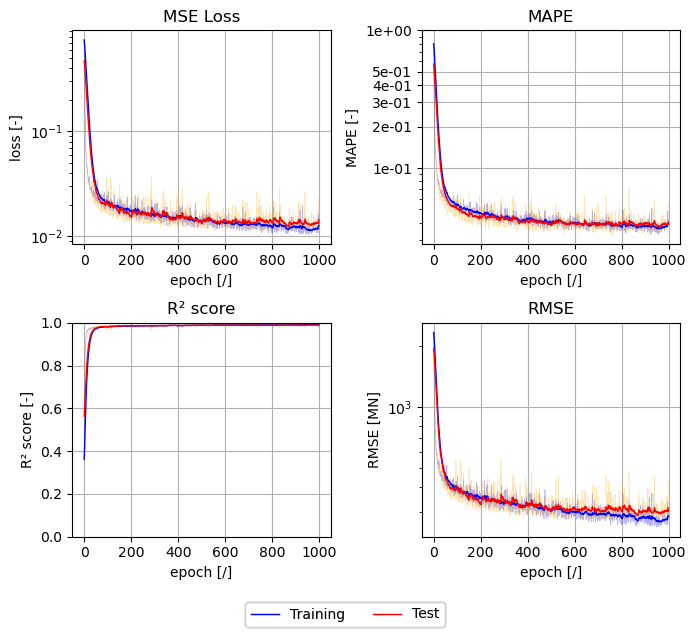

In [3]:
import mlflow
from tools import MLFlowSession
import matplotlib as mpl
from matplotlib import pyplot as plt

server_pinn = MLFlowSession(PORT=5550, DIRECTORY=f"{runs_dir}/114", )
server_pinn.start(1)

mlflow.set_tracking_uri(uri=server_pinn.url())
client = mlflow.MlflowClient()

# Extract Data
experiment = mlflow.get_experiment_by_name("training")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.train_size'] == '4096']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

sizes = set()
for size in runs_df['params.train_size'].unique():
    sizes.add(size)

client = mlflow.tracking.MlflowClient()
results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
for size in sizes:
    run_ids = runs_df[
        (runs_df['params.train_size'] == size)
    ]['run_id']
    for run_id in run_ids:
        for metric_name in metrics_names:
            results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

for k in results.keys():
    for metric in results[k].keys():
        results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

# Plot
metrics = ['loss', 'mape', 'r2', 'rmse_MN']
figsize = (7, 6)
logs = [True, True, False, True]
legend_blank = False
legend_title = r'Training Dataset Size'
titles = ['MSE Loss', 'MAPE', 'R² score', 'RMSE']
axis_titles = ['loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]']
legend_ncols = 4

configs = ['16384']

labels = [f"{int(size)}" for size in configs]

cmap = mpl.colormaps['tab10']
c = cmap(np.linspace(0, 1, 2 * len(configs)))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
axs = [ax for row in axs for ax in row]

for i, (title, y_axis_title, metric, log) in enumerate(zip(titles, axis_titles, metrics, logs)):
    ax = axs[i]
    # Plot the data but collect the handles for the legend
    config_handles = []
    for j, conf in enumerate(configs):
        # Store only the validation line handles for the legend
        l = len(results[conf][f'train_{metric}'])

        train_metric = results[conf][f'train_{metric}']
        test_metric = results[conf][f'val_{metric}']
        if title == 'Stiffness loss':
            train_metric = [1e12 * m for m in train_metric]
            test_metric = [1e12 * m for m in test_metric]
        ax.plot(np.arange(l), train_metric, ls='-', alpha=.3, lw=.5, c='b')[0]
        ax.plot(np.arange(l), test_metric, ls='-', alpha=.3, lw=.5, c='orange')[0]

        mean_train_metric = moving_average(train_metric, alpha=.1)
        mean_test_metric = moving_average(test_metric, alpha=.1)

        if i == 0:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b', label='Training')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r', label='Test')[0]
        else:
            ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c='b')[0]
            ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c='r')[0]

    # Get the current position and size of the axis
    box = ax.get_position()
    # Reduce the width of the axis to make room for the legend
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Combine both sets of handles and labels
    # Create a single legend with both line styles and configurations
    plt.figlegend(loc='upper center', ncols=legend_ncols,
                  bbox_to_anchor=(.5, 0), fontsize=10)

    ax.set_title(title, fontsize=12)
    if log:
        ax.set_yscale('log')
    ax.set_ylabel(f"{y_axis_title}", fontsize=10)
    ax.set_xlabel("epoch [/]", fontsize=10)
    ax.grid()

axs[1].yaxis.set_ticks([.1, .2, .3, .4, .5, 1.])
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
axs[2].set_ylim((0, 1))

fig.tight_layout(w_pad=4)

#for ax in axs[1:2]:
#    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("img/05-pinn-categories-training.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

server_pinn.terminate()

MLflow server started at http://127.0.0.1:5551
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114
Workers: 4
Process group: 73694


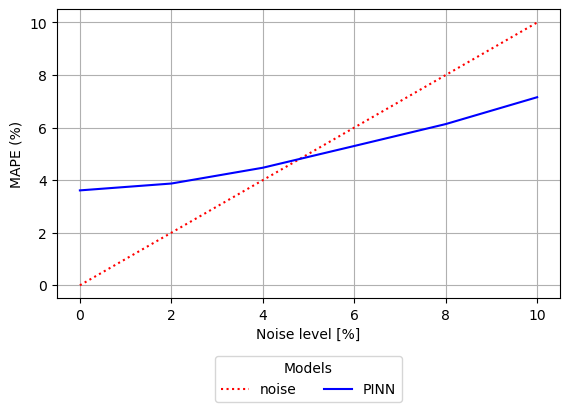

In [5]:
from tools import MLFlowSession
import mlflow
import numpy as np
import matplotlib.pyplot as plt

server_pinn = MLFlowSession(PORT=5551, DIRECTORY=f"{runs_dir}/114", )
server_pinn.start(1)

mlflow.set_tracking_uri(uri=server_pinn.url())
client = mlflow.MlflowClient()

# Extract Data
experiment = mlflow.get_experiment_by_name("noise_sensitivity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
#runs_df = runs_df[runs_df['params.train_size'] == '4096']

cols = [c for c in runs_df if c.startswith('metrics.')]
metrics_names = [col[col.index('.') + 1:] for col in cols]

id = runs_df[
    (runs_df['params.train_size'] == str(2 ** 14)) &
    (runs_df['params.test_set'] == 'category_ea')
    ]['run_id'].iloc[0]

mapes = np.array([m.value for m in client.get_metric_history(id, 'mape')])

# MAPE Plot
fig, ax = plt.subplots(figsize=(5.8, 4.3))
plt.plot(100 * np.linspace(0, .1, 11), 100 * np.linspace(0, .1, 11), label='noise', linestyle=':', c='r')
ax.plot(np.linspace(0, .1, len(mapes)) * 100, mapes * 100, linestyle='-', c='blue', label="PINN")

# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Move legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.175), ncols=3, title="Models", fontsize=10)

lim = ax.get_ylim()
#ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/05-mlp_categories_pinn_noise.pdf", bbox_inches='tight', transparent=True)

plt.show()
#server.terminate()

MLflow server started at http://127.0.0.1:5250
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111
Workers: 4
Process group: 73703
MLflow server started at http://127.0.0.1:5253
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114
Workers: 4
Process group: 73719


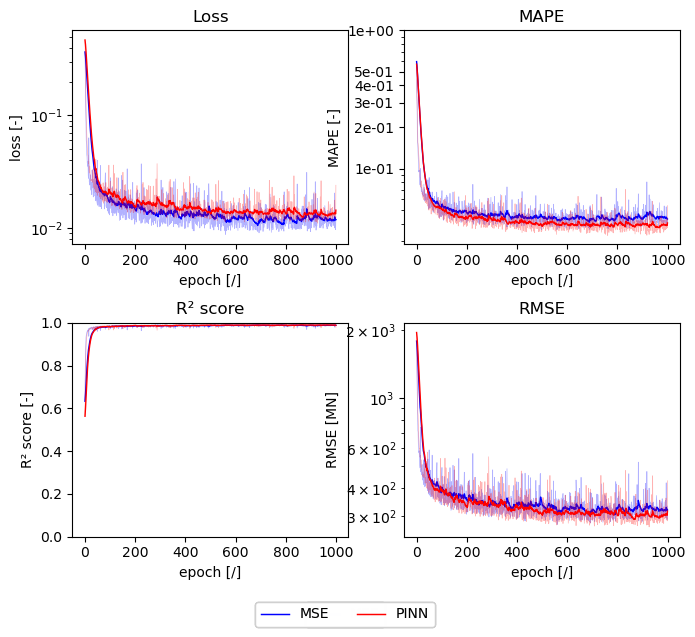

In [6]:
import mlflow
from tools import MLFlowSession
import matplotlib as mpl
from matplotlib import pyplot as plt

server_mlp = MLFlowSession(PORT=5250, DIRECTORY=f"{runs_dir}/111", )
server_mlp.start(3)
server_pinn = MLFlowSession(PORT=5253, DIRECTORY=f"{runs_dir}/114", )
server_pinn.start(6)
figsize = (7, 6)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
axs = [ax for row in axs for ax in row]


def routine(server, axs, c_train=None, label_train=None, label_test=None, c_test=None, ):
    mlflow.set_tracking_uri(uri=server.url())
    client = mlflow.MlflowClient()

    experiment = mlflow.get_experiment_by_name("training")
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    #runs_df = runs_df[runs_df['params.train_size'] == '4096']

    cols = [c for c in runs_df if c.startswith('metrics.')]
    metrics_names = [col[col.index('.') + 1:] for col in cols]

    sizes = set()
    for size in runs_df['params.train_size'].unique():
        sizes.add(size)

    client = mlflow.tracking.MlflowClient()
    results = {k1: {k2: [] for k2 in metrics_names} for k1 in sizes}
    for size in sizes:
        run_ids = runs_df[
            (runs_df['params.train_size'] == size)
        ]['run_id']
        for run_id in run_ids:
            for metric_name in metrics_names:
                results[size][metric_name].append([m.value for m in client.get_metric_history(run_id, metric_name)])

    for k in results.keys():
        for metric in results[k].keys():
            results[k][metric] = np.vstack(results[k][metric]).mean(axis=0)

    # Plot
    metrics = ['loss', 'mape', 'r2', 'rmse_MN']
    figsize = (7, 6)
    logs = [True, True, False, True]
    legend_blank = False
    legend_title = r'Training Dataset Size'
    titles = ['Loss', 'MAPE', 'R² score', 'RMSE']
    axis_titles = ['loss [-]', 'MAPE [-]', 'R² score [-]', 'RMSE [MN]']
    legend_ncols = 4

    configs = ['16384']

    labels = [f"{int(size)}" for size in configs]

    cmap = mpl.colormaps['tab10']
    c = cmap(np.linspace(0, 1, 2 * len(configs)))

    for i, (title, y_axis_title, metric, log) in enumerate(zip(titles, axis_titles, metrics, logs)):
        ax = axs[i]
        # Plot the data but collect the handles for the legend
        config_handles = []
        for j, conf in enumerate(configs):
            # Store only the validation line handles for the legend
            l = len(results[conf][f'train_{metric}'])

            train_metric = results[conf][f'train_{metric}']
            test_metric = results[conf][f'val_{metric}']
            if title == 'Stiffness loss':
                train_metric = [1e12 * m for m in train_metric]
                test_metric = [1e12 * m for m in test_metric]
            if c_train: ax.plot(np.arange(l), train_metric, ls='-', alpha=.3, lw=.5, c=c_train)[0]
            if c_test: ax.plot(np.arange(l), test_metric, ls='-', alpha=.3, lw=.5, c=c_test)[0]

            mean_train_metric = moving_average(train_metric, alpha=.1)
            mean_test_metric = moving_average(test_metric, alpha=.1)

            if i == 0:
                if c_train: ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c=c_train, label=label_train)[0]
                if c_test: ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c=c_test, label=label_test)[0]
            else:
                if c_train: ax.plot(np.arange(l), mean_train_metric, ls='-', lw=1, c=c_train)[0]
                if c_test: ax.plot(np.arange(l), mean_test_metric, ls='-', lw=1, c=c_test)[0]

        # Get the current position and size of the axis
        box = ax.get_position()
        # Reduce the width of the axis to make room for the legend
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Combine both sets of handles and labels
        # Create a single legend with both line styles and configurations
        plt.figlegend(loc='upper center', ncols=legend_ncols,
                      bbox_to_anchor=(.5, 0), fontsize=10)

        ax.set_title(title, fontsize=12)
        if log:
            ax.set_yscale('log')
        ax.set_ylabel(f"{y_axis_title}", fontsize=10)
        ax.set_xlabel("epoch [/]", fontsize=10)
        ax.grid()


routine(server_mlp, axs, c_test='b', label_test='MSE')
routine(server_pinn, axs, c_test='r', label_test='PINN')

axs[1].yaxis.set_ticks([.1, .2, .3, .4, .5, 1.])
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
axs[2].set_ylim((0, 1))

fig.tight_layout(w_pad=4)

#for ax in axs[1:2]:
#    ax.set_ylim([min(.099, ax.get_ylim()[0]), ax.get_ylim()[1]])

plt.savefig("img/05-comparison-categories-training.pdf", transparent=True, bbox_inches='tight')
plt.show()
plt.close()

server_mlp.terminate()
server_pinn.terminate()

MLflow server started at http://127.0.0.1:5451
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114
Workers: 4
Process group: 73739
MLflow server started at http://127.0.0.1:5350
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111
Workers: 4
Process group: 73745


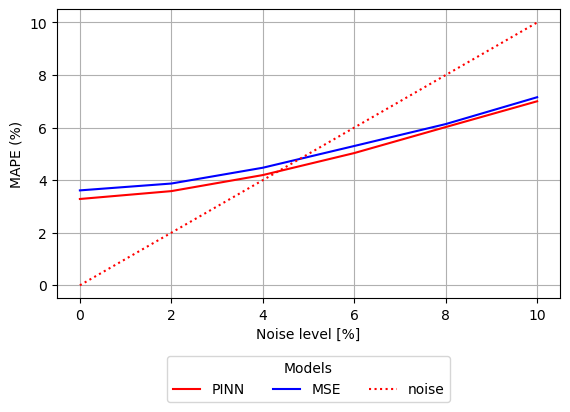

In [8]:
from tools import MLFlowSession
import mlflow
import numpy as np
import matplotlib.pyplot as plt

server_pinn = MLFlowSession(PORT=5451, DIRECTORY=f"{runs_dir}/114", )
server_pinn.start(3)
server_mlp = MLFlowSession(PORT=5350, DIRECTORY=f"{runs_dir}/111", )
server_mlp.start(3)


fig, ax = plt.subplots(figsize=(5.8, 4.3))
def routine(server, ax, label, color):
    # Extract Data
    mlflow.set_tracking_uri(uri=server.url())
    client = mlflow.MlflowClient()
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    #runs_df = runs_df[runs_df['params.train_size'] == '4096']

    cols = [c for c in runs_df if c.startswith('metrics.')]
    metrics_names = [col[col.index('.') + 1:] for col in cols]

    id = runs_df[
        (runs_df['params.train_size'] == str(2 ** 14)) &
        (runs_df['params.test_set'] == 'category_ea')
        ]['run_id'].iloc[0]

    mapes = np.array([m.value for m in client.get_metric_history(id, 'mape')])

    # MAPE Plot
    ax.plot(np.linspace(0, .1, len(mapes)) * 100, mapes * 100, linestyle='-', c=color, label=label)

routine(server_pinn, ax, 'PINN', 'r')
routine(server_mlp, ax, 'MSE', 'b')
# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

plt.plot(100 * np.linspace(0, .1, 11), 100 * np.linspace(0, .1, 11), label='noise', linestyle=':', c='r')

# Move legend outside the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.175), ncols=3, title="Models", fontsize=10)

lim = ax.get_ylim()
#ax.set_yticks(np.hstack((ax.get_yticks(), np.arange(0, 13, 2))))
ax.set_ylim(lim)

plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/05-comparison-categories-noise.pdf", bbox_inches='tight', transparent=True)

plt.show()
#server.terminate()

MLflow server started at http://127.0.0.1:6550
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/111
Workers: 4
Process group: 74077
MLflow server started at http://127.0.0.1:6555
Metadata database: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114/mlruns.db
Artifacts directory: /Users/aflamant/Documents/courses/2024-2025/mémoire/05-results/114
Workers: 4
Process group: 74084


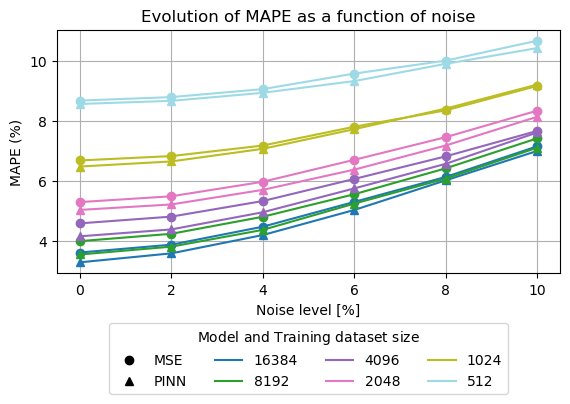

Server not running.


In [8]:
from tools import MLFlowSession
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl


server_mlp = MLFlowSession(PORT=6550, DIRECTORY=f"{runs_dir}/111", )
server_mlp.start(wait_time=3)
server_hybrid = MLFlowSession(PORT=6555, DIRECTORY=f"{runs_dir}/114")
server_hybrid.start(wait_time=3)

mlflow.set_tracking_uri(uri=server_mlp.url())
experiment = mlflow.get_experiment_by_name("noise_sensitivity")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
sizes = runs_df['params.train_size'].unique()
sizes = sorted(sizes, key=lambda s: -int(s))[:-1]

def get_mape(server, size='4096'):
    mlflow.set_tracking_uri(uri=server.url())
    experiment = mlflow.get_experiment_by_name("noise_sensitivity")

    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    runs_df = runs_df[
        (runs_df['params.train_size'] == size) &
        (runs_df['params.test_set'] == 'category_ea')
    ]

    id = list(runs_df['run_id'])[0]
    client = mlflow.tracking.MlflowClient()
    hist = client.get_metric_history(id, 'mape')
    return np.array([m.value for m in hist])


fig, ax = plt.subplots(figsize=(5.8, 4.3))  # Wider figure for space

cmap = mpl.colormaps['tab20']
c = cmap(np.linspace(0, 1, len(sizes)))

for i, size in enumerate(sizes):
    mape_mlp = get_mape(server_mlp, size)
    mape_pinn = get_mape(server_hybrid, size)

    plt.plot(100 * np.linspace(0, .1, len(mape_mlp)), 100 * mape_mlp, marker='o', c=c[i], label=size)
    plt.plot(100 * np.linspace(0, .1, len(mape_pinn)), 100 * mape_pinn, marker='^', c=c[i])

# Labels and formatting
ax.set_ylabel("MAPE (%)", fontsize=10)
ax.set_title("Evolution of MAPE as a function of noise", fontsize=12)
ax.set_xlabel("Noise level [%]", fontsize=10)
ax.grid(True)

# Custom handles for model types
marker_handles = [
    Line2D([], [], color='black', marker='o', linestyle='None', label='MSE'),
    Line2D([], [], color='black', marker='^', linestyle='None', label='PINN')
]

# Legend for training sizes
size_handles = [Line2D([], [], color=c[i], linestyle='-', label=size) for i, size in enumerate(sizes)]

# Combine and add legend
all_handles = marker_handles + size_handles
all_labels = [h.get_label() for h in all_handles]

ax.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.175), ncols=4,
          fontsize=10, title=r"$\text{Model and Training dataset size}$")
plt.tight_layout()  # Make room for legend

# Save
fig.savefig(r"img/05-categories-comparison-noise-size.pdf", transparent=True, bbox_inches='tight')
plt.show()

server_mlp.terminate()
server_hybrid.terminate()